# Import Libraries

In [1]:
!pip install transformers sentencepiece sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 13.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import string
import random
import torch
import math

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.utils import resample
from sklearn.utils import resample
from transformers import MarianMTModel, MarianTokenizer

warnings.filterwarnings("ignore", category=FutureWarning)
# Ensure stopwords are available
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

2025-05-06 16:32:20.574508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746549140.958207      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746549141.073452      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# EDA & Cleaning

## Merge Datasets

In [3]:
base_path = "/kaggle/input/fake-news-detection-datasets/News _dataset"

fake_df = pd.read_csv(f"{base_path}/Fake.csv")
true_df = pd.read_csv(f"{base_path}/True.csv")
fake_df['labels'] = 'fake'
true_df['labels'] = 'true'

merged_df = pd.concat([fake_df, true_df], ignore_index=True)
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

## Show Basic Info

In [4]:
def show_basic_info(df):
    print("Merged Dataset - Basic Info:")
    print(df.info())
    print("\nShape (rows, columns):", df.shape)
    print("\nFirst 5 rows:")
    print(df.head())

show_basic_info(merged_df)

Merged Dataset - Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   labels   44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB
None

Shape (rows, columns): (44898, 5)

First 5 rows:
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. P

<span style="font-size:16px">
Datasets có gần 45000 sample, 4 features gồm:<br>
    + title: tiêu đề bài báo<br>
    + text: nội dung bài báo<br>
    + subject: chủ đề bài báo<br>
    + date: ngày xuất bản
</span>

## Explore Label Distribution

Label distribution:
labels
fake    23481
true    21417
Name: count, dtype: int64

Percentage:
labels
fake    52.3
true    47.7
Name: count, dtype: float64


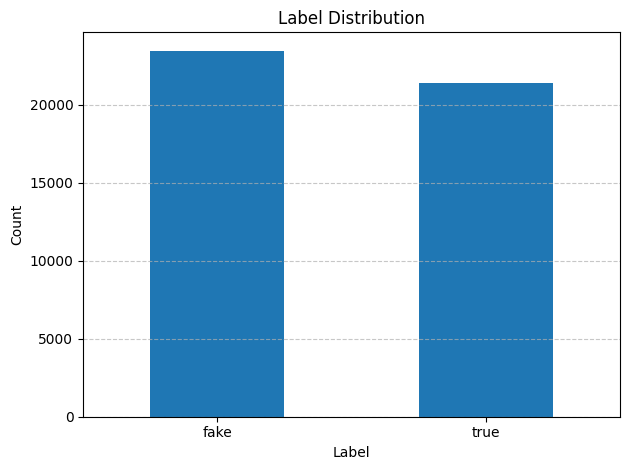

In [5]:
def explore_label_distribution(df):
    """
    Plot the distribution of 'labels' to check class balance (e.g., fake vs true).
    """
    label_counts = df['labels'].value_counts()
    label_percentages = round(label_counts / len(df) * 100, 2)

    print("Label distribution:")
    print(label_counts)
    print("\nPercentage:")
    print(label_percentages)

    label_counts.plot(kind='bar', title='Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

explore_label_distribution(merged_df)

<span style="font-size:16px">
Số lượng fake news và true news không quá chênh lệch nhau
</span>

## Explore Subject Distribution


Subject vs Label counts:
labels           fake   true
subject                     
Government News  1570      0
Middle-east       778      0
News             9050      0
US_News           783      0
left-news        4459      0
politics         6841      0
politicsNews        0  11272
worldnews           0  10145


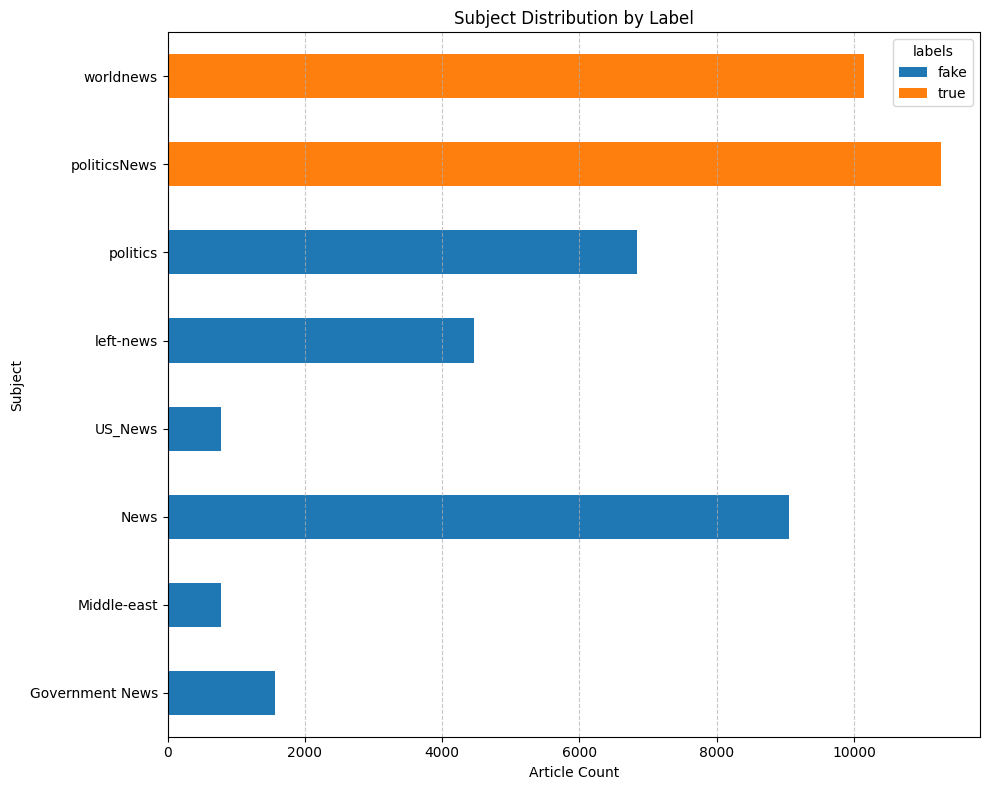

In [6]:
def explore_subject_distribution(df):
    """
    Plot the distribution of 'subject' colored by label to identify if any subject is dominated by a single label.
    """
    subject_label_counts = df.groupby(['subject', 'labels']).size().unstack(fill_value=0)
    print("\nSubject vs Label counts:")
    print(subject_label_counts)

    subject_label_counts.plot(kind='barh', stacked=True, figsize=(10, 8), title='Subject Distribution by Label')
    plt.xlabel('Article Count')
    plt.ylabel('Subject')
    plt.tight_layout()
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

explore_subject_distribution(merged_df)

<span style="font-size:16px">
Fake news có nhiều chủ đề hơn true news, chủ đề của chúng không giống nhau.<br>
Cần loại bỏ subject để tránh model chỉ học trên subject mà không học nội dung.
</span>

## Analyze Text Lengths

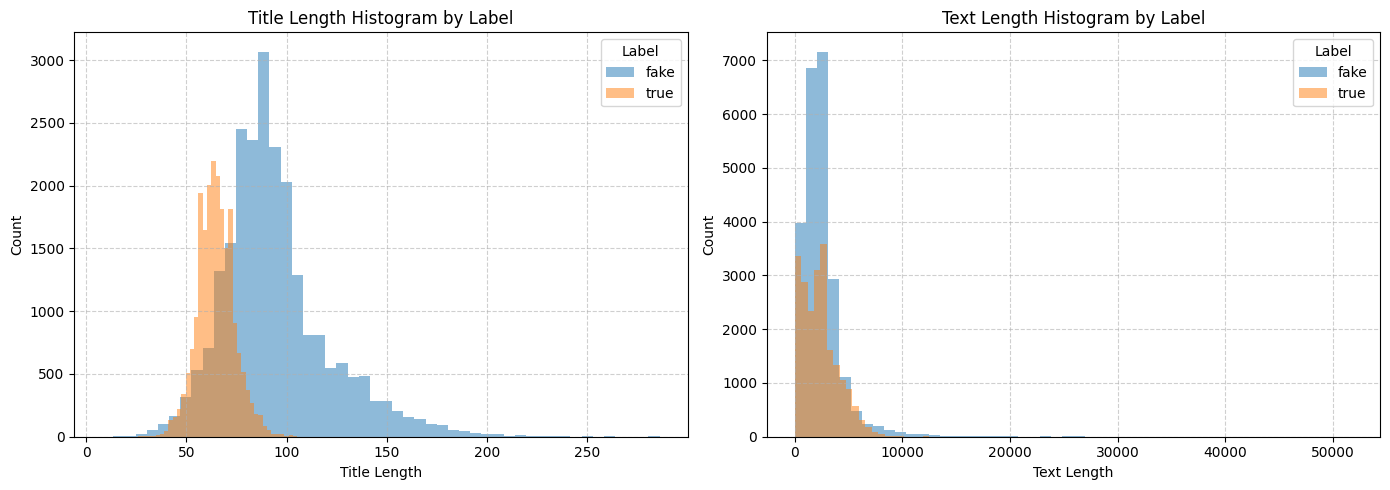

In [7]:
def plot_length_histograms(df):
    """
    Plot histograms of title and text lengths grouped by label.
    """
    df['title_len'] = df['title'].astype(str).apply(len)
    df['text_len'] = df['text'].astype(str).apply(len)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    for label in df['labels'].unique():
        subset = df[df['labels'] == label]
        axes[0].hist(subset['title_len'], bins=50, alpha=0.5, label=label)
    axes[0].set_title("Title Length Histogram by Label")
    axes[0].set_xlabel("Title Length")
    axes[0].set_ylabel("Count")
    axes[0].legend(title="Label")
    axes[0].grid(True, linestyle='--', alpha=0.6)

    for label in df['labels'].unique():
        subset = df[df['labels'] == label]
        axes[1].hist(subset['text_len'], bins=50, alpha=0.5, label=label)
    axes[1].set_title("Text Length Histogram by Label")
    axes[1].set_xlabel("Text Length")
    axes[1].set_ylabel("Count")
    axes[1].legend(title="Label")
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

plot_length_histograms(merged_df)

<span style="font-size:16px">
Title length và cả text length của fake news trải rộng hơn true news.<br>
Chứng tỏ fake news có xu hướng title có nhiều từ giật gân, text thì dài để chứng minh luận điểm.
</span>

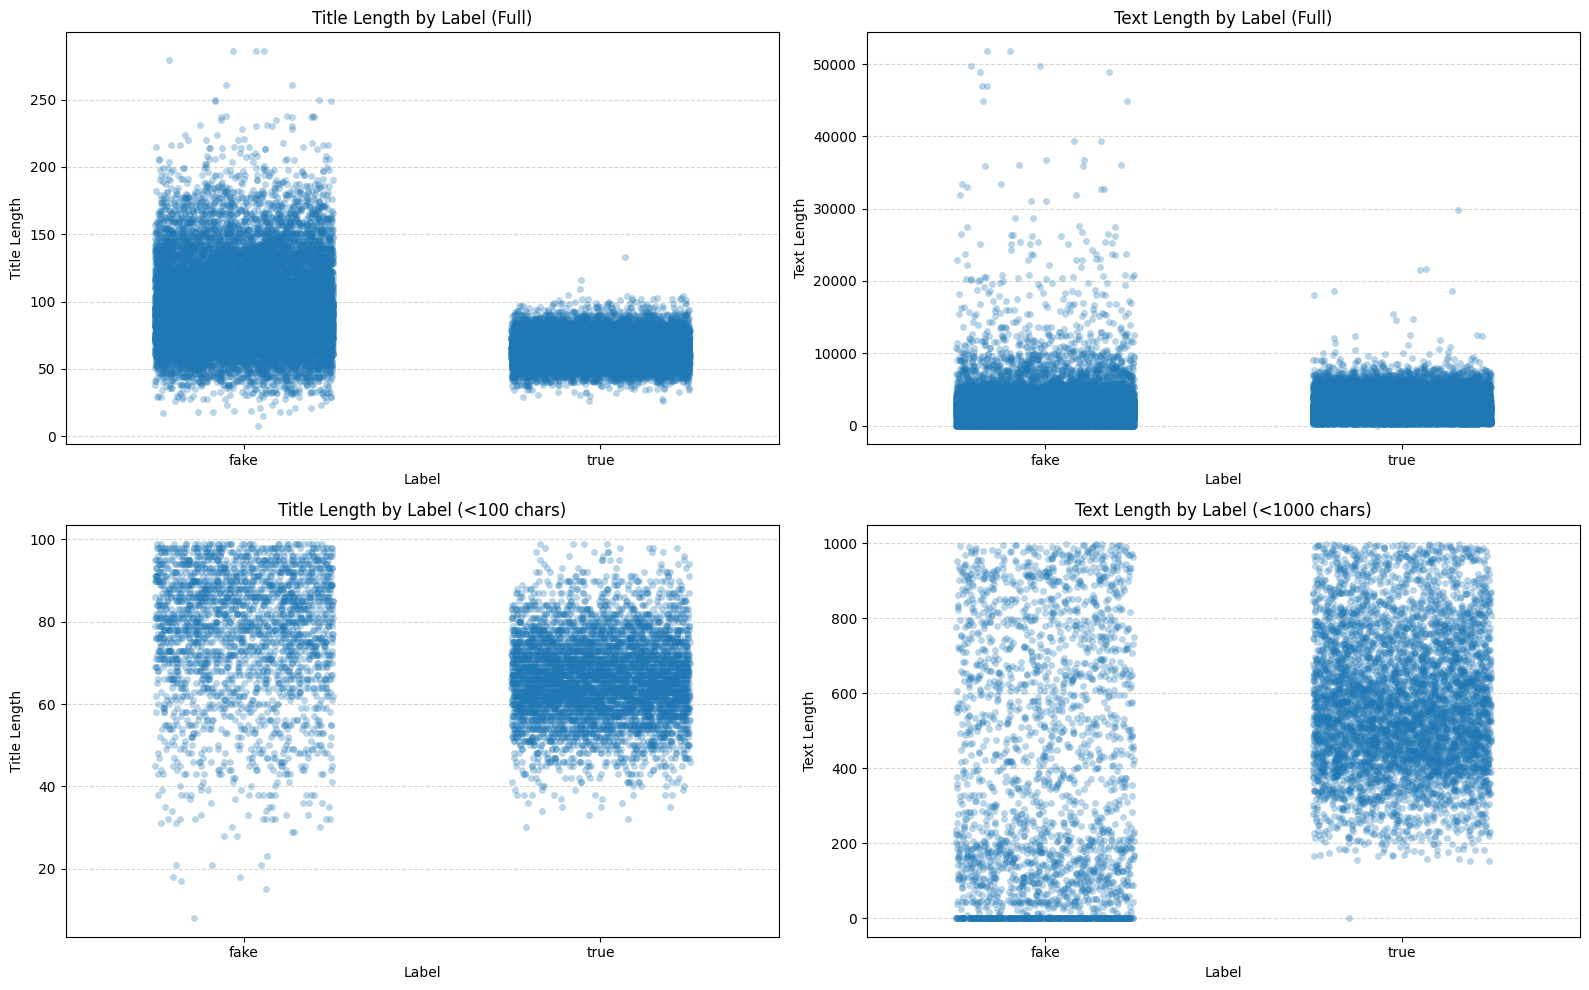

In [8]:
def analyze_text_lengths(df):
    """
    Create a 2x2 subplot showing:
    - Full title length by label
    - Full text length by label
    - Short title length (<100 chars) by label
    - Short text length (<1000 chars) by label
    """
    df['title_len'] = df['title'].astype(str).apply(len)
    df['text_len'] = df['text'].astype(str).apply(len)

    df_small = df[(df['title_len'] < 100) & (df['text_len'] < 1000)]

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Full title length
    sns.stripplot(data=df, x='labels', y='title_len', alpha=0.3, jitter=0.25, ax=axes[0, 0])
    axes[0, 0].set_title('Title Length by Label (Full)')
    axes[0, 0].set_xlabel('Label')
    axes[0, 0].set_ylabel('Title Length')
    axes[0, 0].grid(True, axis='y', linestyle='--', alpha=0.5)

    # Full text length
    sns.stripplot(data=df, x='labels', y='text_len', alpha=0.3, jitter=0.25, ax=axes[0, 1])
    axes[0, 1].set_title('Text Length by Label (Full)')
    axes[0, 1].set_xlabel('Label')
    axes[0, 1].set_ylabel('Text Length')
    axes[0, 1].grid(True, axis='y', linestyle='--', alpha=0.5)

    # Short title length
    sns.stripplot(data=df_small, x='labels', y='title_len', alpha=0.3, jitter=0.25, ax=axes[1, 0])
    axes[1, 0].set_title('Title Length by Label (<100 chars)')
    axes[1, 0].set_xlabel('Label')
    axes[1, 0].set_ylabel('Title Length')
    axes[1, 0].grid(True, axis='y', linestyle='--', alpha=0.5)

    # Short text length
    sns.stripplot(data=df_small, x='labels', y='text_len', alpha=0.3, jitter=0.25, ax=axes[1, 1])
    axes[1, 1].set_title('Text Length by Label (<1000 chars)')
    axes[1, 1].set_xlabel('Label')
    axes[1, 1].set_ylabel('Text Length')
    axes[1, 1].grid(True, axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

analyze_text_lengths(merged_df)

<span style="font-size:16px">
Từ các biểu đồ trên (stripplot & histogram) thì ta thấy có thể loại bỏ bớt outliers (các bài báo có title hoặc text quá ngắn hoặc quá dài).
</span>

## Cleaning Missing Values and Length-Based Outliers

In [9]:
def count_title_text_by_length_bounds(df, title_min=0, title_max=None, text_min=0, text_max=None):
    """
    Count rows where title/text character length is below or above specified thresholds.
    Also prints how many of them are 'fake' or 'true'.
    """
    def char_count(text):
        return len(str(text))

    df['title_len'] = df['title'].apply(char_count)
    df['text_len'] = df['text'].apply(char_count)

    title_below = df[df['title_len'] < title_min]
    title_above = df[df['title_len'] > title_max] if title_max is not None else pd.DataFrame()

    text_below = df[df['text_len'] < text_min]
    text_above = df[df['text_len'] > text_max] if text_max is not None else pd.DataFrame()

    print(f"Title character count < {title_min}: {len(title_below)} rows")
    print(title_below['labels'].value_counts())

    if title_max is not None:
        print(f"Title character count > {title_max}: {len(title_above)} rows")
        print(title_above['labels'].value_counts())

    print(f"Text character count < {text_min}: {len(text_below)} rows")
    print(text_below['labels'].value_counts())

    if text_max is not None:
        print(f"Text character count > {text_max}: {len(text_above)} rows")
        print(text_above['labels'].value_counts())

min_title_length = 30
max_title_length = 150
min_text_length = 150
max_text_length = 10000
count_title_text_by_length_bounds(merged_df, min_title_length, max_title_length, 
                                 min_text_length, max_text_length)

Title character count < 30: 38 rows
labels
fake    34
true     4
Name: count, dtype: int64
Title character count > 150: 1017 rows
labels
fake    1017
Name: count, dtype: int64
Text character count < 150: 1299 rows
labels
fake    1298
true       1
Name: count, dtype: int64
Text character count > 10000: 352 rows
labels
fake    328
true     24
Name: count, dtype: int64


<span style="font-size:16px">
Ta sẽ loại bỏ các bài báo có độ dài tiêu đề dưới 30 hoặc trên 150 ký tự, hoặc nội dung bài viết có độ dài dưới 150 hoặc trên 10.000 ký tự.
</span>

In [10]:
def clean_dataset_by_length_and_missing(df, title_min=0, title_max=None, text_min=0, text_max=None):
    """
    Remove rows with:
    - title length < title_min or > title_max
    - text length < text_min or > text_max
    - missing title, text, or date
    - duplicated rows
    """
    df = df.copy()
    df['title_len'] = df['title'].astype(str).apply(len)
    df['text_len'] = df['text'].astype(str).apply(len)

    conditions = (
        (df['title_len'] >= title_min) &
        (df['text_len'] >= text_min) &
        df['title'].notna() &
        df['text'].notna() &
        df['date'].notna()
    )

    if title_max is not None:
        conditions &= df['title_len'] <= title_max
    if text_max is not None:
        conditions &= df['text_len'] <= text_max

    df_cleaned = df[conditions].drop_duplicates()
    removed_count = len(df) - len(df_cleaned)

    print(f"Removed rows: {removed_count}")
    print(f"Remaining rows after cleaning: {len(df_cleaned)}")

    return df_cleaned

merged_df = clean_dataset_by_length_and_missing(merged_df, min_title_length, max_title_length,
                                   min_text_length, max_text_length) 

Removed rows: 2867
Remaining rows after cleaning: 42031


Label distribution:
labels
true    21182
fake    20849
Name: count, dtype: int64

Percentage:
labels
true    50.4
fake    49.6
Name: count, dtype: float64


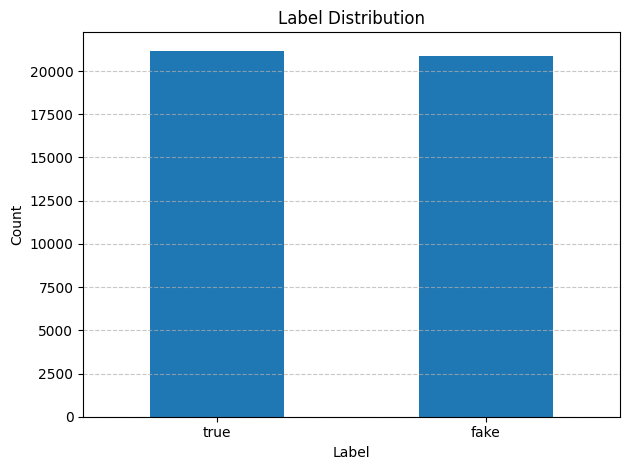

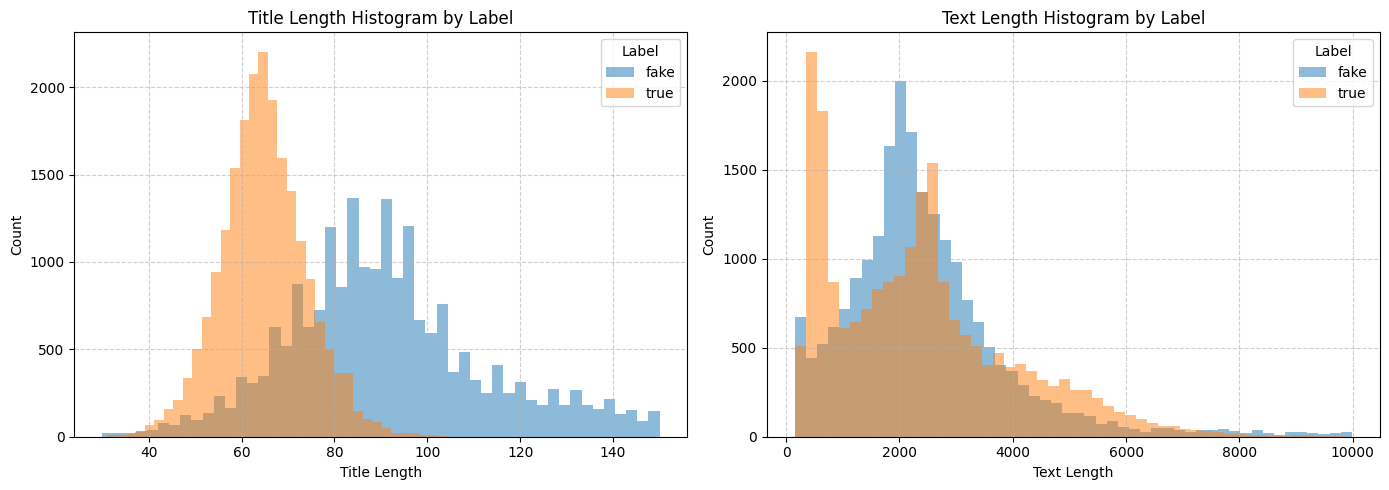

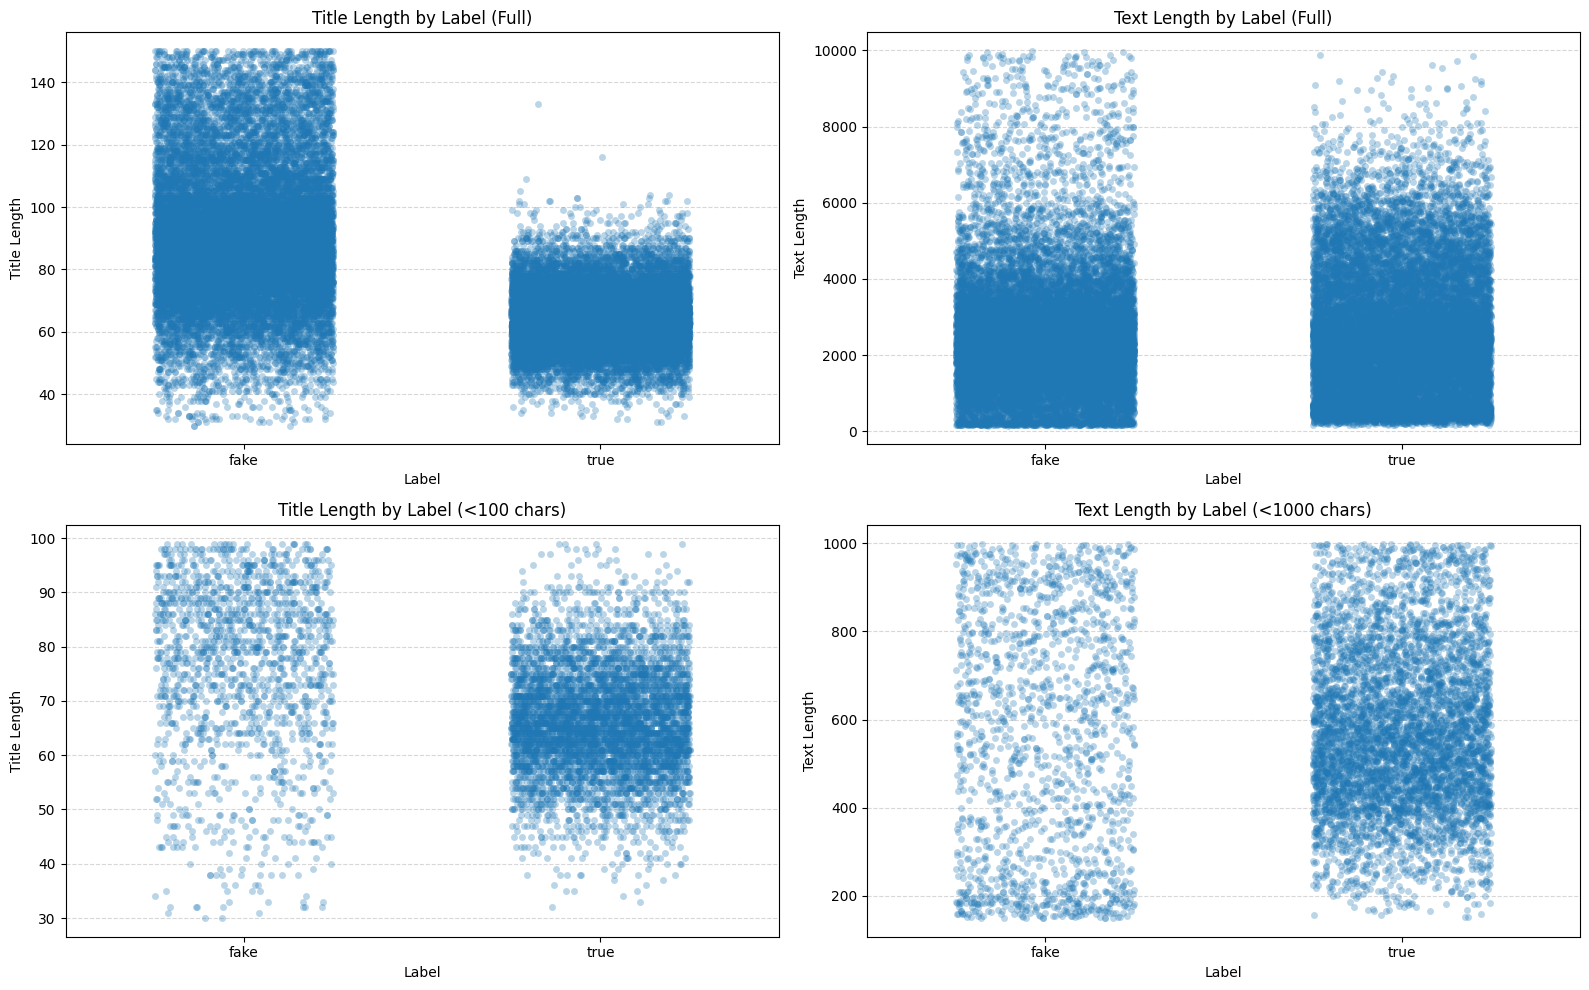

In [11]:
explore_label_distribution(merged_df)
plot_length_histograms(merged_df)
analyze_text_lengths(merged_df)

<span style="font-size:16px">
Số lượng true và fake hiện tại đã gần như cân bằng hoàn hảo.<br>
<br>
Tiêu đề (title) của fake news có xu hướng dài hơn, phân bố rộng và lệch phải nhưng đã được giảm bớt (tầm 1000 rows).<br>
Fake news thường giật tít, nhấn mạnh cảm xúc hoặc gây tò mò, nên tiêu đề dài.<br>
True news tuân theo phong cách báo chí chuẩn, tiêu đề ngắn gọn, súc tích.<br>
<br>
Nội dung (text) của fake news và true news có độ dài khá tương đồng.<br>
Nội dung (text) của fake news có nhiều bài rất ngắn, đã được loại bỏ (hơn 1200 rows).
</span>

## Explore Text

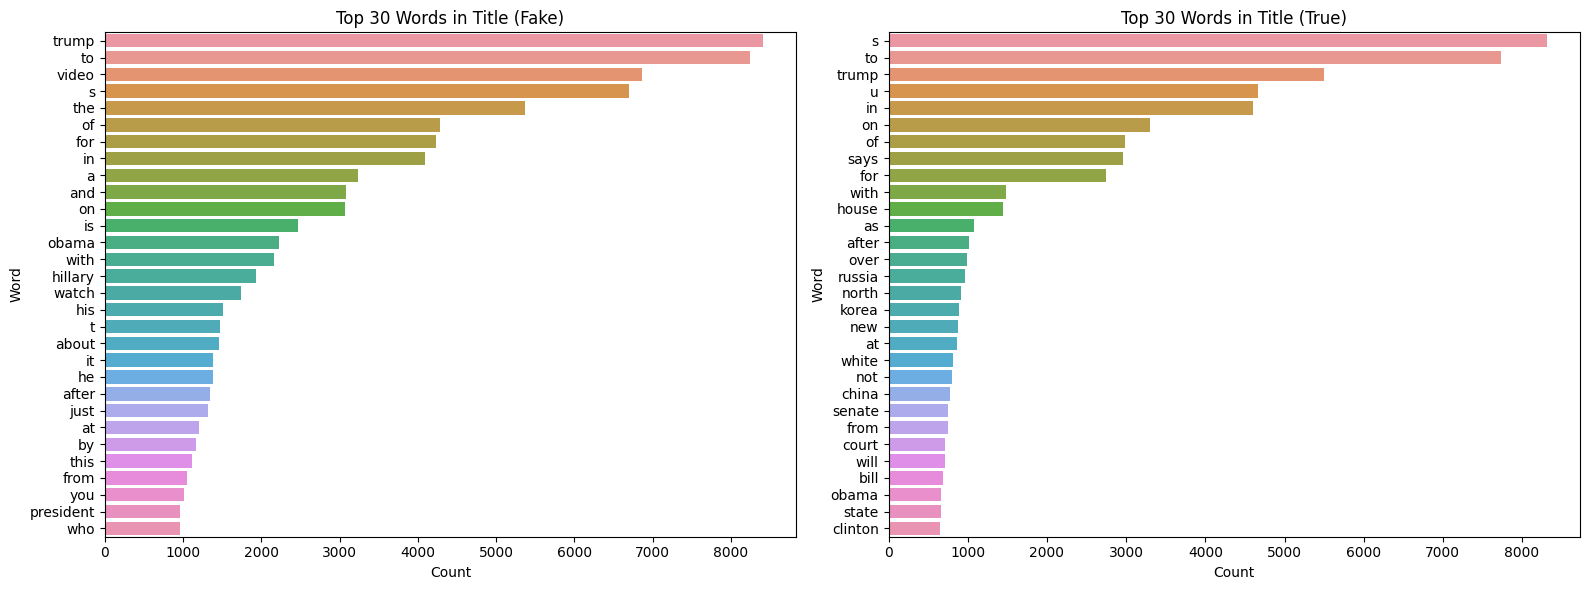

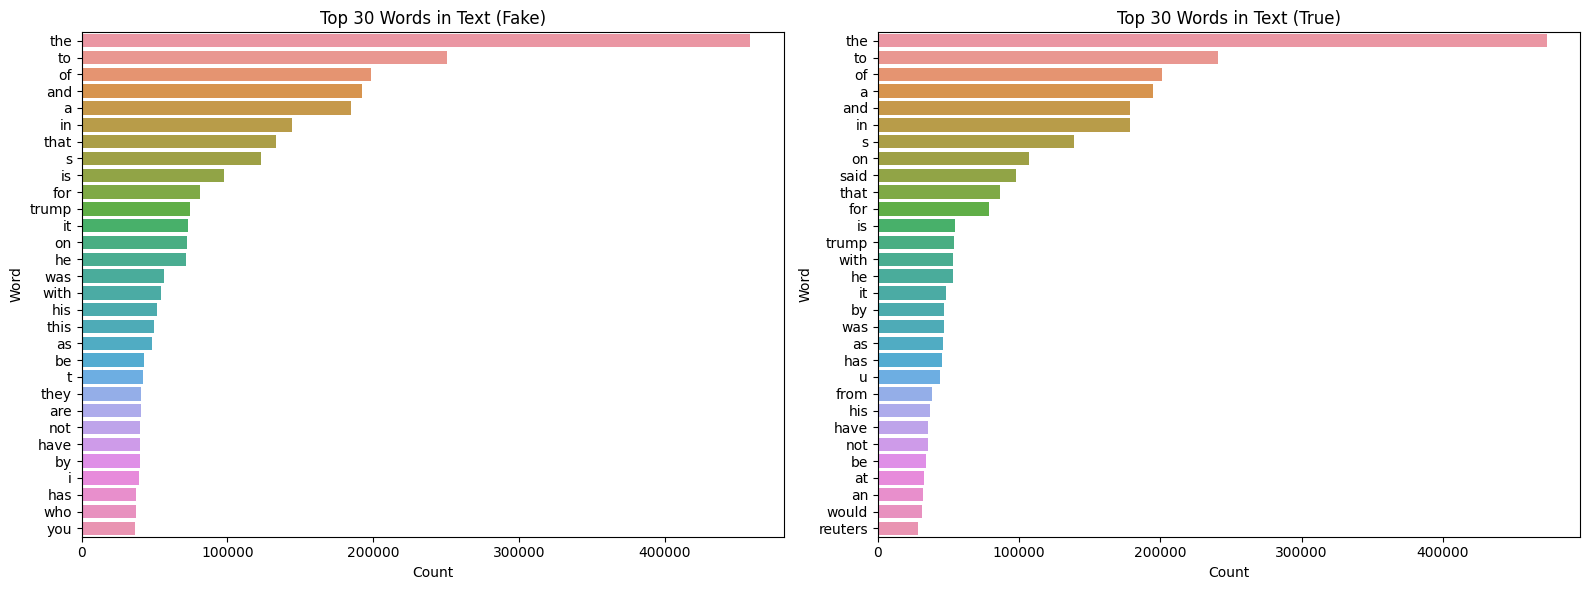

In [12]:
def plot_common_words(df, column='text', top_n=30):
    """
    Plot most common words in a text column by label ('fake' vs 'true').
    """
    def clean_text(text):
        return re.findall(r"\b\w+\b", str(text).lower())

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for ax, label in zip(axes, ['fake', 'true']):
        texts = df[df['labels'] == label][column].dropna().apply(clean_text)
        word_counts = Counter(word for tokens in texts for word in tokens)
        common = word_counts.most_common(top_n)
        words, counts = zip(*common)

        sns.barplot(x=list(counts), y=list(words), ax=ax)
        ax.set_title(f"Top {top_n} Words in {column.capitalize()} ({label.title()})")
        ax.set_xlabel("Count")
        ax.set_ylabel("Word")

    plt.tight_layout()
    plt.show()

plot_common_words(merged_df, 'title')
plot_common_words(merged_df, 'text')

<span style="font-size:16px">
Top words đang có phần nhiều là stopwords.
</span>

<span style="font-size:18px">
Remove stopwords.
</span>

In [13]:
def remove_stopwords(text):
    """
    Remove English stopwords from a text string.
    """
    tokens = str(text).split()
    return ' '.join([word for word in tokens if word.lower() not in stop_words])

tqdm.pandas(desc="Removing Stopwords in title")
merged_df['title'] = merged_df['title'].progress_apply(remove_stopwords)
tqdm.pandas(desc="Removing Stopwords in text")
merged_df['text'] = merged_df['text'].progress_apply(remove_stopwords)

Removing Stopwords in text: 100%|██████████| 42031/42031 [00:03<00:00, 13233.27it/s]


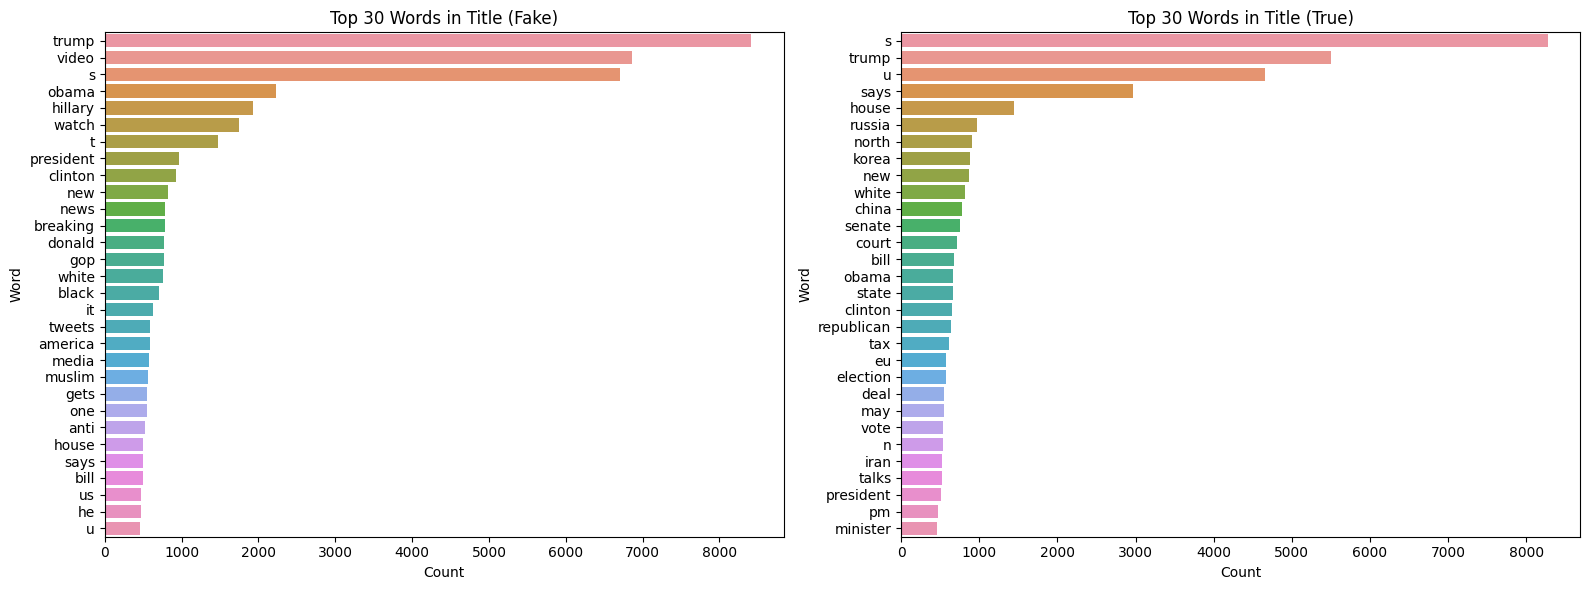

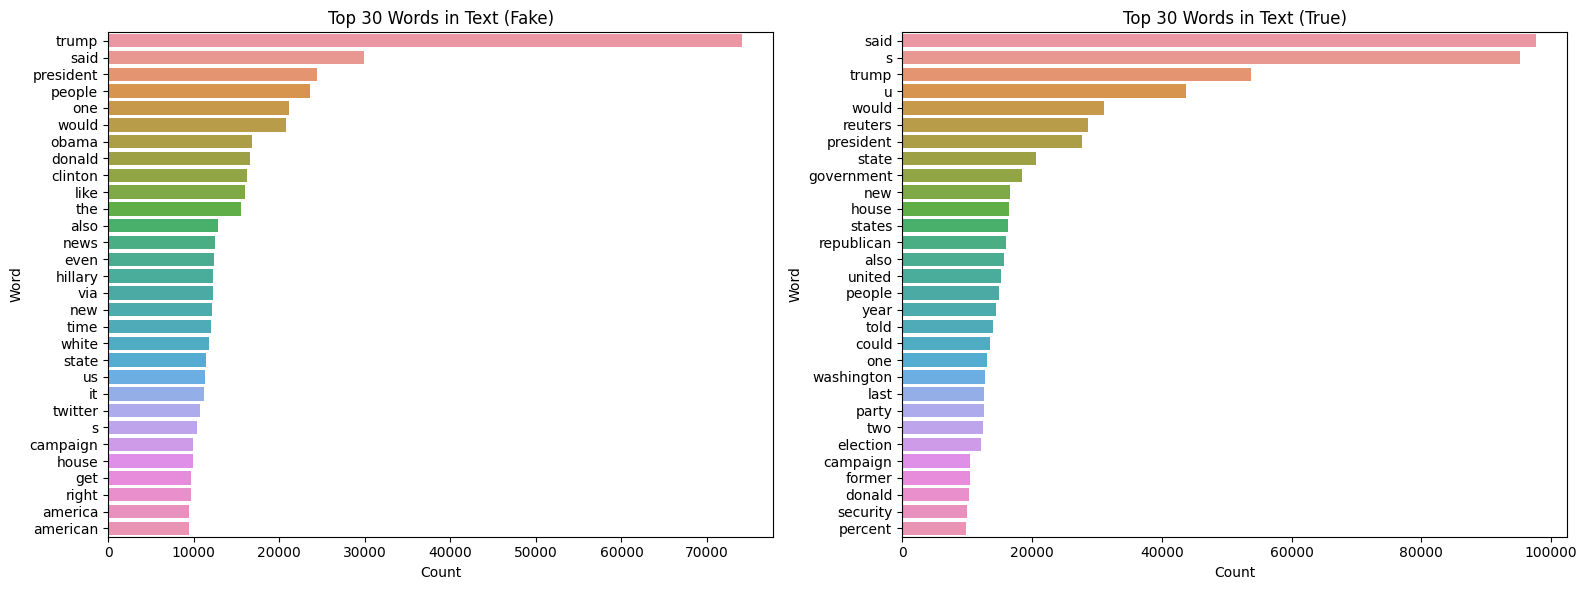

In [14]:
plot_common_words(merged_df, 'title')
plot_common_words(merged_df, 'text')

<span style="font-size:16px">
Sau khi loại bỏ stopwords thì thấy fake news có title sử dụng từ gop (viết tắt của đảng cộng hoà) và tweets khá nhiều (khả nghi nên xem kĩ hơn).<br>
Còn nội dung (text) thì fake news dùng từ via (trích dẫn) và twitter khá nhiều, có vẻ data của fake được thu thập từ twitter. True news thì dùng từ reuters (tên một tờ báo nổi tiếng, uy tín) rất nhiều, có vẻ data của true thì được thu nhập từ đầu báo đó.
</span>

In [15]:
def count_rows_containing_word(df, word, label=None, column='text'):
    """
    Count how many rows in df[column] contain the given word (case-insensitive).
    Optionally filter by label ('fake' or 'true').
    
    Parameters:
    - df: pandas DataFrame
    - word: keyword to search for (as exact word)
    - label: optional, filter by 'fake' or 'true'
    - column: 'text' or 'title' (default is 'text')
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")

    pattern = rf'\b{re.escape(word)}\b'  # exact word match with word boundaries

    if label:
        subset = df[(df['labels'] == label) & (df[column].str.contains(pattern, case=False, na=False))]
    else:
        subset = df[df[column].str.contains(pattern, case=False, na=False)]

    print(f"Rows containing '{word}' in column '{column}'"
          + (f" with label '{label}'" if label else "")
          + f": {len(subset)}")
    
    # return subset

print("In title:")
count_rows_containing_word(merged_df, "gop", "fake", "title")
count_rows_containing_word(merged_df, "gop", "true", "title")
count_rows_containing_word(merged_df, "tweets", "fake", "title")
count_rows_containing_word(merged_df, "tweets", "true", "title")

print("\nIn text:")
count_rows_containing_word(merged_df, "reuters", "fake")
count_rows_containing_word(merged_df, "reuters", "true")
count_rows_containing_word(merged_df, "via", "fake")
count_rows_containing_word(merged_df, "via", "true")
count_rows_containing_word(merged_df, "twitter", "fake")
count_rows_containing_word(merged_df, "twitter", "true")

In title:
Rows containing 'gop' in column 'title' with label 'fake': 762
Rows containing 'gop' in column 'title' with label 'true': 8
Rows containing 'tweets' in column 'title' with label 'fake': 582
Rows containing 'tweets' in column 'title' with label 'true': 31

In text:
Rows containing 'reuters' in column 'text' with label 'fake': 275
Rows containing 'reuters' in column 'text' with label 'true': 21145
Rows containing 'via' in column 'text' with label 'fake': 10808
Rows containing 'via' in column 'text' with label 'true': 464
Rows containing 'twitter' in column 'text' with label 'fake': 5136
Rows containing 'twitter' in column 'text' with label 'true': 1724


<span style="font-size:16px">
Từ số lượng và độ lệch ở trên, để tránh model học shortcuts thì ta sẽ loại bỏ từ via và reuters khỏi nội dung (text).
</span>

In [16]:
def print_random_texts_by_label(df, label='fake', n=5, max_length=2000):
    """
    Print n random samples with the given label and text length < max_length.
    """
    subset = df[(df['labels'] == label) & (df['text'].astype(str).str.len() < max_length)]
    
    if len(subset) < n:
        print(f"Only found {len(subset)} rows matching criteria.")
        n = len(subset)
    
    samples = subset.sample(n)

    for i, row in samples.iterrows():
        print("=" * 80)
        print(f"Index: {i}")
        print(f"Title: {row['title']}")
        print(f"Text:\n{row['text']}")
        print("=" * 80)


print("fake")
print_random_texts_by_label(merged_df, label='fake')
print('\n\ntrue')
print_random_texts_by_label(merged_df, label='true')

fake
Index: 37257
Title: Trump Gets ANNIHILATED Immigration GOP Debate Must-See Video (VIDEO)
Text:
months, debate raged: 2016 hopeful Marco Rubio robot, he? Thursday GOP debate might prove wrong Rubio. unclear happened maybe someone upgraded operating system maybe, maybe, flesh-and-blood person. whatever is, Florida Senator wiped floor Donald must-see catfight.It unclear got Rubio. Maybe someone installed Windows 10. Maybe got good night rest once. Perhaps one supporters shared crack pipe. never know. case, Rubio fire surprisingly animated catfight billionaire bankruptcy expert (To clear, blow fuse; meant figuratively).During discussion regarding Trump promised Wall (with capital W ) 10 feet taller thanks brilliant f*ck former President Mexico, Vicente Fox, Rubio unleashed inner something: builds wall like built Trump Tower, using illegal immigrant labor it. two rambled simultaneously while, Rubio CPU (or adrenaline) kicked overdrive, dropped hammer: guy inherited 200 million dollars.

<span style="font-size:16px">
Có thể thấy fake news thì thường có @ (trong mail hoặc twitter handle), đường link (https) và từ via (trích dẫn).<br>
Còn true news thì có Reuters - chính là ghi về source của bài báo (trích dẫn từ nguồn uy tín). Phần lớn true news đều có từ này.
</span>

In [17]:
def show_fake_texts_with_emails(df, n=3):
    """
    Show up to n fake news texts that contain an email address.
    """
    email_pattern = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b"
    matches = df[(df['labels'] == 'fake') & (df['text'].str.contains(email_pattern, na=False))]

    print(f"Found {len(matches)} fake texts containing emails.\n")
    for i, row in matches.head(n).iterrows():
        print("=" * 80)
        print(f"Index: {i}")
        print(f"Title: {row['title']}")
        print(f"Text:\n{row['text']}")

def show_fake_texts_with_urls(df, n=3):
    """
    Show up to n fake news texts that contain a URL.
    """
    url_pattern = r'https?://\S+|www\.\S+'
    matches = df[(df['labels'] == 'fake') & (df['text'].str.contains(url_pattern, na=False))]

    print(f"Found {len(matches)} fake texts containing URLs.\n")
    for i, row in matches.head(n).iterrows():
        print("=" * 80)
        print(f"Index: {i}")
        print(f"Title: {row['title']}")
        print(f"Text:\n{row['text']}")


show_fake_texts_with_emails(merged_df)
print('\n\n')
show_fake_texts_with_urls(merged_df)

Found 37 fake texts containing emails.

Index: 1526
Title: BREAKING EMAIL LEAK: “Bernie needs ground pulp…Crush hard can”
Text:
Hey Bernie whole Queen Wall Street/ Democrat mob boss endorsement working you?Wikileaks released another batch emails. One emails likely Joel Johnson, Managing Director Glover Park Group, Washington DC firm specializing strategic communications government relationsThe email sent Feb. 2, 2016 John Podesta subject matter: Friendly advice. mercy. From:Joel@gpg.com To: john.podesta@gmail.com Date: 2016-02-22 00:09 Subject: Friendly advice. mercy.Bernie needs ground pulp. start believing primary bullshit. time run general. Crush hard can. that, hope well congrats Nevada!Only 4 days ago, Hill named GPG Joel Johnson one Top Lobbyists Hired Guns 2016:Joel Johnson, Glover Park GroupClients trusted guide Johnson, former Clinton administration official leads advocacy efforts public relations powerhouse.Buzzfeed September 2015, Susan Brophy, managing director Glover Park 

<span style="font-size:16px">
Ta sẽ cần loại bỏ email và link khỏi data.
</span>

## Cleaning and Normalization Text

In [18]:
def normalize_text(text):
    """
    Normalize text by:
    - Lowercasing
    - Removing URLs and emails
    - Removing the word 'reuters' (case-insensitive)
    - Keeping only letters, numbers, dots, and spaces
    - Replacing repeated dots with a single dot
    - Normalizing whitespace
    """
    text = str(text).lower()
    # Remove URLs and emails
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b", '', text)
    # Remove the word 'reuters' (source of article)
    text = re.sub(r'\breuters\b\s*', '', text, flags=re.IGNORECASE)
    # Remove the word 'via' (often used to indicate source)
    text = re.sub(r'\bvia\b\s*', '', text, flags=re.IGNORECASE)
    # Keep only letters, digits, dot, and whitespace
    text = re.sub(r'[^a-z0-9.\s]', ' ', text)
    # Replace multiple dots with a single one
    text = re.sub(r'\.{2,}', '.', text)
    # Normalize extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def normalize_title_text_columns(df):
    df = df.copy()
    tqdm.pandas(desc="Normalizing title columns")
    df['title'] = df['title'].progress_apply(normalize_text)
    tqdm.pandas(desc="Normalizing text columns")
    df['text'] = df['text'].progress_apply(normalize_text)
    return df

merged_df_clean = normalize_title_text_columns(merged_df)

Normalizing text columns: 100%|██████████| 42031/42031 [00:11<00:00, 3628.81it/s]


In [19]:
show_fake_texts_with_emails(merged_df_clean)
print('\n\n')
show_fake_texts_with_urls(merged_df_clean)

Found 0 fake texts containing emails.




Found 0 fake texts containing URLs.



In [20]:
count_rows_containing_word(merged_df_clean, "reuters", "fake")
count_rows_containing_word(merged_df_clean, "reuters", "true")
count_rows_containing_word(merged_df_clean, "via", "fake")
count_rows_containing_word(merged_df_clean, "via", "true")

Rows containing 'reuters' in column 'text' with label 'fake': 0
Rows containing 'reuters' in column 'text' with label 'true': 0
Rows containing 'via' in column 'text' with label 'fake': 0
Rows containing 'via' in column 'text' with label 'true': 0


In [21]:
# Lọc index với text length < 2000
short_text_indices = merged_df[merged_df['text'].astype(str).str.len() < 2000].index

# Lấy ngẫu nhiên 1 index từ các dòng đủ điều kiện
idx = random.sample(list(short_text_indices), 1)[0]

# Hiển thị kết quả
print(idx, merged_df.loc[idx, 'labels'])
print("\nsample title before clean:\n", merged_df.loc[idx, 'title'])
print("sample title after clean:\n", merged_df_clean.loc[idx, 'title'])

print("\nsample text before clean:\n", merged_df.loc[idx, 'text'])
print("sample text after clean:\n", merged_df_clean.loc[idx, 'text'])


10142 fake

sample title before clean:
 Secret Society Ruined World: Rhodes, Rothschild, Milner
sample title after clean:
 secret society ruined world rhodes rothschild milner

sample text before clean:
 IMAGE: Globalist scribe American branch international order, Carol Quigley.Jay Dyer 21st Century WireIn partial video, continue analysis Quigley later work, Anglo American Establishment, following upon lectures last year total 1300 pages Tragedy Hope. Here, look deeper key players make real Illuminati successfully engineered faux democracy modern world, run shadow banking-corporate empire.This addendum 8 lectures last year monumental Atlanticist apologetic Tragedy Hope based Quigley telling book, Anglo-American Establishment. first section free, subscribers gain access full talks lectures. goals Rhodes Milner sought methods hoped achieve similar 1902 two almost indistinguishable sought unite world, English-speaking world federal structure around Britain. felt goal could best achieved s

In [22]:
print("fake")
print_random_texts_by_label(merged_df_clean, label='fake')
print('\n\ntrue')
print_random_texts_by_label(merged_df_clean, label='true')

fake
Index: 39660
Title: boiler room ep 86 kek comes pizzatown
Text:
tune alternate current radio network acr another live broadcast boiler room starting 6 00 pm pst 8 00 pm cst 9 00 pm est special broadcast. join us uncensored uninterruptible talk radio custom made barfly philosophers misguided moralists masochists street corner evangelists media maniacs savants political animals otherwise lovable rascals.join acr hosts hesher spore along patrick henningsen 21st century wire andy nowicki alt right blogspot stewart howe randy j both 21st century wire daniel spaulding soul east boiler regulars drag deep state research 86th episode boiler room. water plants put kids bed get favorite snuggy drop deep boiler room acr brain trust.caller line open tonight 1 218 936 0912 passcode 267457 please like share program visit donate page get involved boiler room polictally correct zone listen show player enjoy listen boiler room 86 spreaker.reference links
Index: 43388
Title: liberal media promotes h

In [23]:
merged_df = merged_df_clean

## Parse Date & Explore Date Distribution

In [24]:
def parse_dates(df):
    """
    Convert 'date' column to datetime format using mixed formats. Store parsed result in 'date_parsed' column.
    Drop rows with invalid dates and report how many were removed.
    """
    original_len = len(df)
    df['date_parsed'] = pd.to_datetime(df['date'], format='mixed', errors='coerce')
    df_invalid = df[df['date_parsed'].isna()]
    df_cleaned = df.dropna(subset=['date_parsed'])
    removed_count = original_len - len(df_cleaned)

    print(f"Removed {removed_count} rows due to unparseable dates.")
    print("\nSample parsed dates:")
    print(df_cleaned[['date', 'date_parsed']].head())
    print("\nSample of removed rows:")
    print(df_invalid['date'].head())

    return df_cleaned

merged_df = parse_dates(merged_df)
print(merged_df.shape)

Removed 0 rows due to unparseable dates.

Sample parsed dates:
                  date date_parsed
0    February 13, 2017  2017-02-13
1       April 5, 2017   2017-04-05
2  September 27, 2017   2017-09-27
3         May 22, 2017  2017-05-22
4       June 24, 2016   2016-06-24

Sample of removed rows:
Series([], Name: date, dtype: object)
(42031, 8)


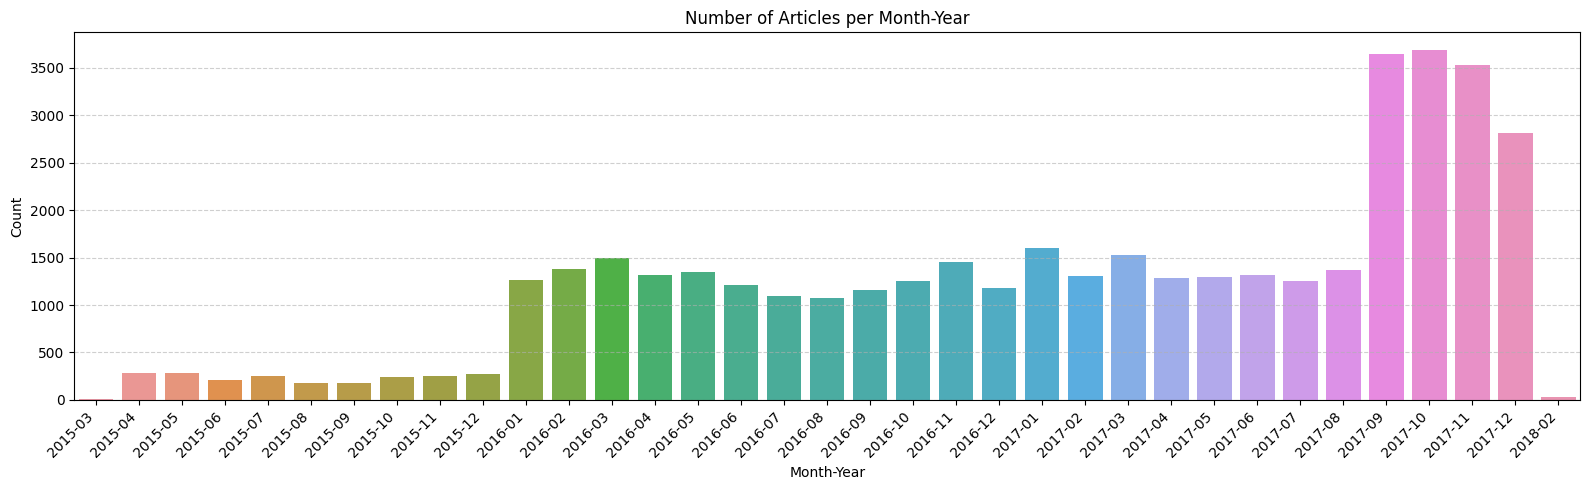

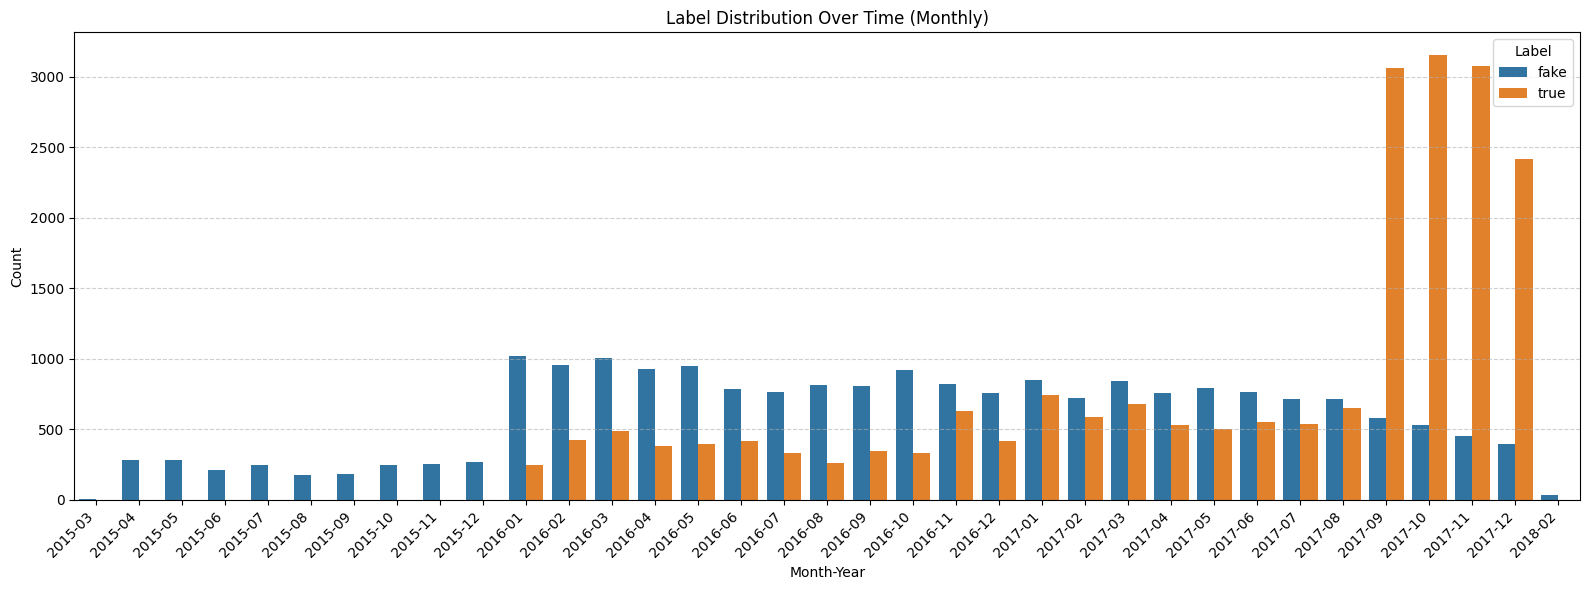

In [25]:
def explore_date_distribution(df):
    """
    Plot article count per month-year and label distribution over time.
    """
    df['month_year'] = df['date_parsed'].dt.to_period('M').astype(str)
    month_order = sorted(df['month_year'].unique())

    # Plot total articles per month-year
    plt.figure(figsize=(16, 5))
    ax1 = sns.countplot(data=df, x='month_year', order=month_order)
    plt.title('Number of Articles per Month-Year')
    plt.xlabel('Month-Year')
    plt.ylabel('Count')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Plot label distribution over time
    plt.figure(figsize=(16, 6))
    ax2 = sns.countplot(data=df, x='month_year', hue='labels', order=month_order)
    plt.title('Label Distribution Over Time (Monthly)')
    plt.xlabel('Month-Year')
    plt.ylabel('Count')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    plt.legend(title='Label')
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

explore_date_distribution(merged_df)

<span style="font-size:16px">
Có thể thấy trước năm 2016 đổ về trước thì tất cả đều là fake news.<br>
Từ năm 2016 đến tháng 8 năm 2017 thì lượng fake news luôn nhiều hơn true news.<br>
Từ tháng 9 năm 2017 đến hết 2017 thì true news nhiều hơn fake news rất nhiều. <br>
</span>

In [26]:
def count_articles_by_period(df):
    """
    Count number of articles and label breakdown for custom time periods.
    """
    conditions = {
        "Until end of 2015": df['date_parsed'] <= pd.to_datetime("2015-12-31"),
        "2016 to Jun 2017": (df['date_parsed'] >= pd.to_datetime("2016-01-01")) & (df['date_parsed'] <= pd.to_datetime("2017-06-30")),
        "Jul to 15-Oct 2017": (df['date_parsed'] >= pd.to_datetime("2017-07-01")) & (df['date_parsed'] <= pd.to_datetime("2017-10-15")),
        "16-Oct 2017 onward": df['date_parsed'] >= pd.to_datetime("2017-10-16")
    }

    for period, condition in conditions.items():
        subset = df[condition]
        total = len(subset)
        label_counts = subset['labels'].value_counts()
        print(f"\n{period}:")
        print(f"  Total articles: {total}.", f"Percentage in merged_df: {round(total / len(df) * 100, 2)}%")
        for label in ['fake', 'true']:
            print(f"  {label.title()} articles: {label_counts.get(label, 0)}.", f"Percentage in period: {round(label_counts.get(label, 0) / total * 100, 2)}%")

count_articles_by_period(merged_df)


Until end of 2015:
  Total articles: 2159. Percentage in merged_df: 5.14%
  Fake articles: 2159. Percentage in period: 100.0%
  True articles: 0. Percentage in period: 0.0%

2016 to Jun 2017:
  Total articles: 23558. Percentage in merged_df: 56.05%
  Fake articles: 15272. Percentage in period: 64.83%
  True articles: 8286. Percentage in period: 35.17%

Jul to 15-Oct 2017:
  Total articles: 7947. Percentage in merged_df: 18.91%
  Fake articles: 2251. Percentage in period: 28.33%
  True articles: 5696. Percentage in period: 71.67%

16-Oct 2017 onward:
  Total articles: 8367. Percentage in merged_df: 19.91%
  Fake articles: 1167. Percentage in period: 13.95%
  True articles: 7200. Percentage in period: 86.05%


<span style="font-size:16px">
Ta có thể chia dữ liệu như trên.<br>
Trước năm 2016 thì ta sẽ loại bỏ.<br>
Từ 2016 đến hết tháng 6 2017 để train.<br>
Từ tháng 7 2017 đến hết 15-10 2017 để valid.<br>
Từ tháng 16-10 2017 trở đi thì để test.
</span>

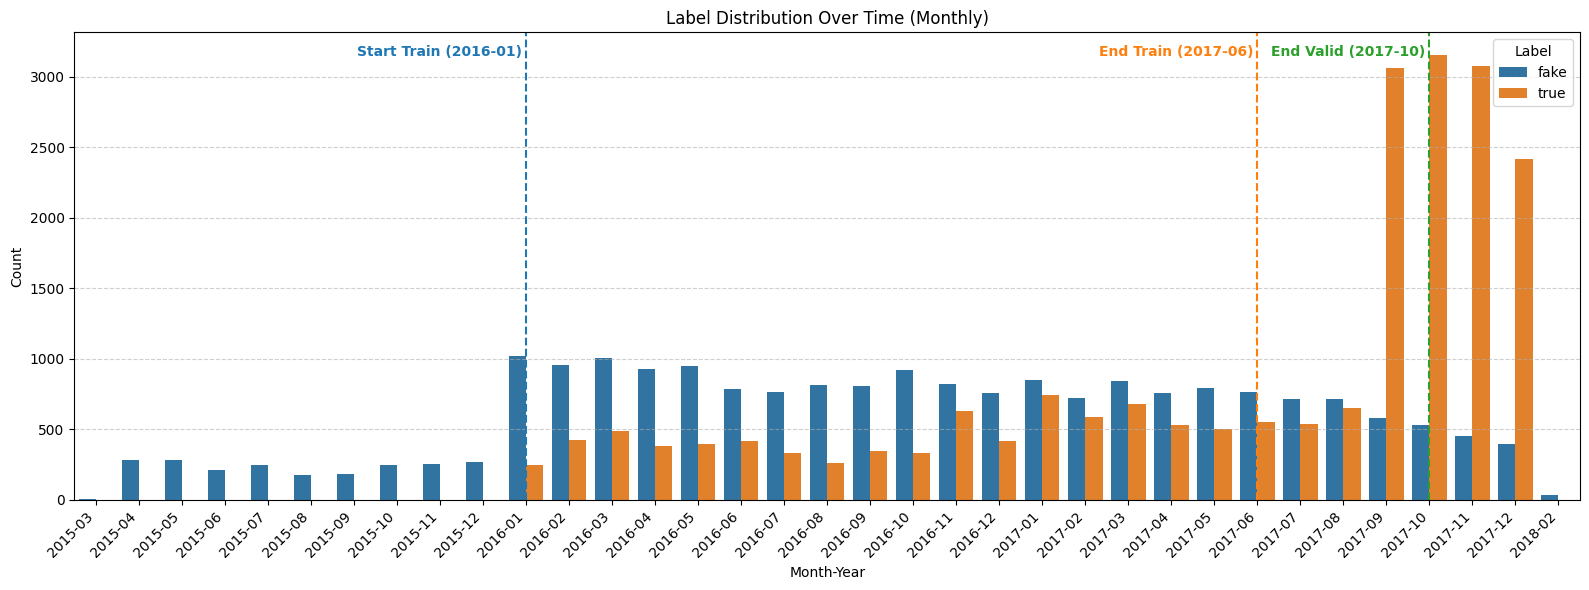

In [27]:
def plot_date_distribution_with_split_lines(df):
    """
    Plot label distribution over time (monthly) with color-coded dashed lines
    and labels placed close to each split.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Tạo thứ tự tháng tăng dần
    month_order = sorted(df['month_year'].unique())

    plt.figure(figsize=(16, 6))
    ax = sns.countplot(data=df, x='month_year', hue='labels', order=month_order)

    # Mốc và màu sắc chia phase
    phase_boundaries = {
        'Start Train (2016-01)': ('2016-01', '#1f77b4'),
        'End Train (2017-06)': ('2017-06', '#ff7f0e'),
        'End Valid (2017-10)': ('2017-10', '#2ca02c')
    }

    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]

    for label, (boundary, color) in phase_boundaries.items():
        if boundary in xtick_labels:
            pos = xtick_labels.index(boundary)
            ax.axvline(pos, color=color, linestyle='--', linewidth=1.5)
            ax.text(pos - 0.1,
                    ax.get_ylim()[1] * 0.95,
                    label,
                    rotation=0,
                    ha='right',
                    fontsize=10,
                    color=color,
                    fontweight='bold')

    plt.title('Label Distribution Over Time (Monthly)')
    plt.xlabel('Month-Year')
    plt.ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.legend(title='Label')
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


plot_date_distribution_with_split_lines(merged_df)

<span style="font-size:16px">
Vẽ thêm đường chia khoảng.
</span>

# Data Splitting

In [28]:
def split_dataset_by_date(df):
    """
    Split the dataset into train, validation, and test sets based on date ranges:
    - Remove entries before 2016
    - Train: from 2016-01-01 to 2017-06-30
    - Validation: from 2017-07-01 to 2017-10-15
    - Test: from 2017-10-16 onward
    Keep only 'title', 'text', 'labels', and parsed date (renamed to 'date') in the output.
    """
    df = df.copy()

    # Ensure date_parsed column exists and is datetime
    df['date_parsed'] = pd.to_datetime(df['date_parsed'])

    # Remove data before 2016
    df = df[df['date_parsed'] >= pd.Timestamp('2016-01-01')]

    # Split the dataset
    train_df = df[df['date_parsed'] <= pd.Timestamp('2017-06-30')]
    valid_df = df[(df['date_parsed'] > pd.Timestamp('2017-06-30')) &
                  (df['date_parsed'] <= pd.Timestamp('2017-10-15'))]
    test_df = df[df['date_parsed'] > pd.Timestamp('2017-10-15')]

    # Keep and rename relevant columns
    cols = ['title', 'text', 'date_parsed', 'labels']
    train_df = train_df[cols].rename(columns={'date_parsed': 'date'})
    valid_df = valid_df[cols].rename(columns={'date_parsed': 'date'})
    test_df = test_df[cols].rename(columns={'date_parsed': 'date'})

    # Show stats
    total = len(df)
    for name, subset in [('Train', train_df), ('Valid', valid_df), ('Test', test_df)]:
        count = len(subset)
        percent = 100 * count / total
        label_counts = subset['labels'].value_counts(normalize=True) * 100
        print(f"\n{name} Set:")
        print(f"- Samples: {count} ({percent:.2f}%)")
        print(f"- Label Distribution:\n{label_counts.round(2)}")

    return train_df, valid_df, test_df

# Split and save
train_df, valid_df, test_df = split_dataset_by_date(merged_df)
train_df.to_csv('train_raw.csv', index=False)
valid_df.to_csv('valid.csv', index=False)
test_df.to_csv('test.csv', index=False)


Train Set:
- Samples: 23558 (59.08%)
- Label Distribution:
labels
fake    64.83
true    35.17
Name: proportion, dtype: float64

Valid Set:
- Samples: 7947 (19.93%)
- Label Distribution:
labels
true    71.67
fake    28.33
Name: proportion, dtype: float64

Test Set:
- Samples: 8367 (20.98%)
- Label Distribution:
labels
true    86.05
fake    13.95
Name: proportion, dtype: float64


In [29]:
train_df

,title,text,date,labels
0,ben stein calls 9th circuit court committed co...,21st century wire says ben stein reputable pro...,2017-02-13,fake
1,trump drops steve bannon national security cou...,washington u.s. president donald trump removed...,2017-04-05,true
3,oops trump accidentally confirmed leaked israe...,monday donald trump embarrassed country accide...,2017-05-22,fake
4,donald trump heads scotland reopen golf resort,glasgow scotland u.s. presidential candidates ...,2016-06-24,true
5,paul ryan responds dem s sit in gun control di...,wednesday democrats took powerful stance gop r...,2016-06-22,fake
...,...,...,...,...
44882,longer suspicion experts trace dnc hacker back...,rumors dnc hack tied russia swirling several d...,2016-07-26,fake
44883,trump totally screwed military children,one one donald trump screwing everyone promise...,2017-02-21,fake
44885,cummings chaffetz reveal major problem trump a...,reps. jason chaffetz r ut elijah cummings d md...,2017-04-25,fake
44891,taxpayer funded left wing church organization ...,church organization church organization takes ...,2016-01-10,fake


In [30]:
valid_df

,title,text,date,labels
2,puerto rico expects u.s. lift jones act shippi...,puerto rico governor ricardo rossello said wed...,2017-09-27,true
29,factbox battle raqqa islamic state s syrian hq...,beirut battle city raqqa islamic state used he...,2017-10-15,true
34,china urges north korea go dangerous direction,united nations china s foreign minister thursd...,2017-09-21,true
40,georgia governor orders evacuation savannah co...,georgia governor nathan deal issued mandatory ...,2017-09-07,true
47,report corrupt wall streeters three times like...,donald trump chief economic adviser director n...,2017-08-07,fake
...,...,...,...,...
44886,trump lays new iran strategy friday complicati...,washington president donald trump lay confront...,2017-10-12,true
44887,clear discrimination snap still gives preferen...,center immigration studies great resource fact...,2017-07-22,fake
44888,pierre berge co founded yves saint laurent fas...,paris french businessman art patron pierre ber...,2017-09-08,true
44894,pm may seeks ease japan s brexit fears trade v...,london tokyo british prime minister theresa ma...,2017-08-29,true


In [31]:
test_df

,title,text,date,labels
8,north korea shows sign serious talking u.s. of...,washington state department said wednesday uni...,2017-12-13,true
12,france germany want iran reverse ballistic mis...,paris france germany agree iran must reverse b...,2017-12-04,true
13,aide eu commission head tweets picture white s...,brussels martin selmayr top aide head european...,2017-12-08,true
23,governor yemen s interim capital resigns accus...,aden governor president abd rabbu mansour hadi...,2017-11-17,true
30,images suggest north korea aggressive work bal...,washington satellite images taken month north ...,2017-11-17,true
...,...,...,...,...
44880,zimbabwe police charge u.s. citizen anti gover...,harare u.s. citizen charged friday attempting ...,2017-11-03,true
44881,defiant hun sen tells u.s. cut aid cambodia,phnom penh cambodian prime minister hun sen ch...,2017-11-19,true
44889,iraqi pm rebuffs u.s. decree foreign shia mili...,ever since isis appeared iraq 2014 policies st...,2017-10-24,fake
44890,burundi opposition platform boycotts new round...,nairobi burundi main opposition grouping said ...,2017-11-28,true


In [32]:
def oversample_minority_class(df, label_col='labels', target_label='true', majority_label='fake', random_state=42):
    """
    Oversample the minority class to match the number of samples in the majority class.
    Returns a new balanced DataFrame.
    """
    # Separate majority and minority classes
    df_majority = df[df[label_col] == majority_label]
    df_minority = df[df[label_col] == target_label]

    # Oversample minority class
    df_minority_upsampled = resample(
        df_minority,
        replace=True,  # sample with replacement
        n_samples=len(df_majority),  # match number of majority samples
        random_state=random_state
    )

    # Combine majority and oversampled minority
    df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=random_state).reset_index(drop=True)

    print("After Oversampling:")
    print(df_balanced[label_col].value_counts(normalize=True).round(2) * 100)

    return df_balanced

# Example usage:
train_df_balanced_oversample = oversample_minority_class(train_df)


After Oversampling:
labels
fake    50.0
true    50.0
Name: proportion, dtype: float64


In [33]:
train_df_balanced_oversample

,title,text,date,labels
0,ron paul syria chaos ever since obama said ass...,21st century wire says ron paul told rt us eng...,2016-09-29,fake
1,house panel seeks fbi department justice docum...,washington house intelligence committee thursd...,2017-05-18,true
2,fannie freddie stocks open higher mnuchin s re...,new york shares fannie mae freddie mac opened ...,2017-04-26,true
3,leftist legal expert dershowitz calls 9th circ...,harvard law professor emeritus alan dershowitz...,2017-02-09,fake
4,berkeley college thugs form human chain stop w...,students university california berkeley held d...,2016-10-25,fake
...,...,...,...,...
30539,trump says reports russia helped u.s. election...,washington president elect donald trump reject...,2016-12-11,true
30540,researchers used doctored pics obama link raci...,always obvious people half clue better hatred ...,2016-05-15,fake
30541,orrin hatch shuts liberal hack comparing neil ...,judge napolitano explains going great job sena...,2017-04-04,fake
30542,trump weighs next executive orders national se...,aboard air force one u.s. president donald tru...,2017-01-26,true


In [34]:
train_df_balanced_oversample.to_csv('train_oversampling.csv', index=False)

In [35]:
def undersample_majority_class(df, label_col='labels', target_label='true', majority_label='fake', random_state=42):
    """
    Undersample the majority class to match the number of samples in the minority class.
    Returns a new balanced DataFrame.
    """
    # Separate majority and minority classes
    df_majority = df[df[label_col] == majority_label]
    df_minority = df[df[label_col] == target_label]

    # Undersample majority class
    df_majority_downsampled = resample(
        df_majority,
        replace=False,  # sample without replacement
        n_samples=len(df_minority),  # match number of minority samples
        random_state=random_state
    )

    # Combine minority and downsampled majority
    df_balanced = pd.concat([df_minority, df_majority_downsampled]).sample(frac=1, random_state=random_state).reset_index(drop=True)

    print("After Undersampling:")
    print(df_balanced[label_col].value_counts(normalize=True).round(2) * 100)

    return df_balanced

train_df_balanced_undersample = undersample_majority_class(train_df)

After Undersampling:
labels
fake    50.0
true    50.0
Name: proportion, dtype: float64


In [36]:
train_df_balanced_undersample

,title,text,date,labels
0,breaking acting fbi director mccabe contradict...,acting fbi director andrew mccabe testified to...,2017-05-11,fake
1,tv host buys forgives 15m worth u.s. medical debt,21st century wire says latest stunt goes show ...,2016-06-07,fake
2,snap clinton reading pence email headline goes...,photo former presidential candidate hillary cl...,2017-03-04,true
3,unreal pro cuba travel pbs nbc cuba much going...,two examples pro cuba sentiment lefty media tr...,2016-05-05,fake
4,elizabeth warren supporter purchases pocahonta...,elizabeth warren amps attacks donald trump fra...,2016-06-11,fake
...,...,...,...,...
16567,right wing columnist officially begging democr...,new york times conservative columnist david br...,2016-07-04,fake
16568,cnn anchor piles bill o reilly silly sex alleg...,accusations surrounding bill reilly relentless...,2017-04-20,fake
16569,factbox trump meet oklahoma governor ex texas ...,u.s. republican president elect donald trump h...,2016-11-21,true
16570,governor extends flint water emergency state a...,washington michigan governor rick snyder thurs...,2016-01-28,true


In [37]:
train_df_balanced_undersample.to_csv('train_undersampling.csv', index=False)

In [38]:
small_train_df = train_df.sample(n=10, replace=True, random_state=42)
small_train_df

,title,text,date,labels
30002,watch cnn host gets schooled guest comparing o...,facts funny things ever wonder left opposed us...,2016-01-04,fake
1622,kentucky s republican governor calls probe dem...,louisville kentucky s republican governor tues...,2016-04-19,true
10223,watch film barack michelle set debut plot amaze,barack obama life undoubtedly interesting one ...,2016-04-30,fake
41146,trump aide juster nominated u.s. ambassador in...,washington u.s. president donald trump expecte...,2017-06-23,true
22635,fox host don t ban assault weapons terrorists ...,fox news host tucker carlson desperate defend ...,2016-06-19,fake
21377,rights advocates slam trump plans muslim immig...,new york immigrant refugee advocates wednesday...,2017-01-25,true
42152,russia s strange 45 acre maryland compound clo...,washington sits corsica river along eastern sh...,2017-01-01,fake
11861,criminal details emerge washington s fast furi...,21st century wire says doubt it. comparison wa...,2016-04-13,fake
32058,won t believe insane anti obama bullsh t idiot...,saturday illinois newspaper belleville news de...,2016-05-22,fake
8325,gop senator compares obama drug dealer,republican senator compared president obama dr...,2016-08-21,fake


In [39]:
# Load model and assign to specific GPU
def load_translation_model(src_lang='en', tgt_lang='fr', device_id=0):
    model_name = f"Helsinki-NLP/opus-mt-{src_lang}-{tgt_lang}"
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return tokenizer, model, device

# Translate a list of sentences using MarianMT
def translate_sentences(sentences, tokenizer, model, device, batch_size=8):
    results = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            translated = model.generate(
                **inputs,
                max_length=512,
                num_beams=5,
                early_stopping=True
            )
        decoded = tokenizer.batch_decode(translated, skip_special_tokens=True)
        results.extend(decoded)
    return results

# Perform back translation using en→fr→en
def back_translate_text(text, tokenizer_en_fr, model_en_fr, tokenizer_fr_en, model_fr_en, device_fr, device_en):
    sentences = sent_tokenize(text)
    if not sentences:
        return text, [], []
    fr_sentences = translate_sentences(sentences, tokenizer_en_fr, model_en_fr, device_fr)
    back_translated = translate_sentences(fr_sentences, tokenizer_fr_en, model_fr_en, device_en)
    return ' '.join(back_translated), fr_sentences, back_translated

# Back translate a DataFrame
def back_translate_df(df):
    tokenizer_en_fr, model_en_fr, device_fr = load_translation_model('en', 'fr', device_id=0)
    tokenizer_fr_en, model_fr_en, device_en = load_translation_model('fr', 'en', device_id=1)

    bt_df = df.copy()

    for idx, row in tqdm(bt_df.iterrows(), total=len(bt_df), desc="Back Translating Rows"):
        title_bt, title_fr, title_en = back_translate_text(str(row['title']), tokenizer_en_fr, model_en_fr, tokenizer_fr_en, model_fr_en, device_fr, device_en)
        text_bt, text_fr, text_en = back_translate_text(str(row['text']), tokenizer_en_fr, model_en_fr, tokenizer_fr_en, model_fr_en, device_fr, device_en)

        bt_df.at[idx, 'title'] = title_bt
        bt_df.at[idx, 'text'] = text_bt
        bt_df.at[idx, 'date'] = row['date']
        bt_df.at[idx, 'labels'] = row['labels']

        # print(f"\n=== Row {idx} ===")
        # print("[TITLE BEFORE]", row['title'])
        # print("[TITLE FR    ]", ' '.join(title_fr))
        # print("[TITLE AFTER ]", title_bt)
        # print("[TEXT  BEFORE]", row['text'])
        # print("[TEXT  FR    ]", ' '.join(text_fr))
        # print("[TEXT  AFTER ]", text_bt)
    
    return bt_df

# Balance dataset by augmenting the minority class
def balance_with_backtranslation(train_df):
    label_counts = train_df['labels'].value_counts()
    majority_label = label_counts.idxmax()
    minority_label = label_counts.idxmin()

    print(train_df['labels'].value_counts())
    num_to_augment = label_counts[majority_label] - label_counts[minority_label]
    print(f"Augmenting {num_to_augment} samples of class '{minority_label}'")

    minority_df = train_df[train_df['labels'] == minority_label]
    sampled_df = minority_df.sample(n=num_to_augment, replace=True, random_state=42)

    bt_df = back_translate_df(sampled_df)
    tqdm.pandas(desc="Removing Stopwords in title")
    bt_df['title'] = bt_df['title'].progress_apply(remove_stopwords)
    tqdm.pandas(desc="Removing Stopwords in text")
    bt_df['text'] = bt_df['text'].progress_apply(remove_stopwords)
    bt_df = normalize_title_text_columns(bt_df)
    
    combined_df = pd.concat([train_df, bt_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
    return combined_df

balanced_small_df = balance_with_backtranslation(small_train_df)

labels
fake    7
true    3
Name: count, dtype: int64
Augmenting 4 samples of class 'true'


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]


Normalizing text columns: 100%|██████████| 4/4 [00:00<00:00, 2887.15it/s]


In [40]:
balanced_small_df

,title,text,date,labels
0,gop senator compares obama drug dealer,republican senator compared president obama dr...,2016-08-21,fake
1,kentucky republican governor calls probe democ...,louisville kentucky republican governor tuesda...,2016-04-19,true
2,watch cnn host gets schooled guest comparing o...,facts funny things ever wonder left opposed us...,2016-01-04,fake
3,rights human rights defenders slam trouver pla...,new york immigrant refugee defender wednesday ...,2017-01-25,true
4,rights advocates slam trump plans muslim immig...,new york immigrant refugee advocates wednesday...,2017-01-25,true
5,won t believe insane anti obama bullsh t idiot...,saturday illinois newspaper belleville news de...,2016-05-22,fake
6,watch film barack michelle set debut plot amaze,barack obama life undoubtedly interesting one ...,2016-04-30,fake
7,kentucky s republican governor calls probe dem...,louisville kentucky s republican governor tues...,2016-04-19,true
8,rights human rights defenders slam trouver pla...,new york immigrant refugee defender wednesday ...,2017-01-25,true
9,fox host don t ban assault weapons terrorists ...,fox news host tucker carlson desperate defend ...,2016-06-19,fake


In [41]:
train_df_balanced_backtranslation = balance_with_backtranslation(train_df)

labels
fake    15272
true     8286
Name: count, dtype: int64
Augmenting 6986 samples of class 'true'


Normalizing text columns: 100%|██████████| 6986/6986 [00:01<00:00, 3858.50it/s]


In [42]:
train_df_balanced_backtranslation

,title,text,date,labels
0,internet goes newt gingrich s throat old tweet...,donald trump repeatedly attacked former presid...,2017-03-26,fake
1,sour grapes whatever happened smooth transitio...,andrew malcolm mcclatchy news better stop stea...,2017-01-03,fake
2,four u.s. laws urge security agency tackle veh...,washington four republican congress members mo...,2016-09-12,true
3,dem lawmaker out trolls internet troll calling...,internet vicious place openly gay lawmaker got...,2017-04-27,fake
4,biden netanyahu discuss iran islamic state syr...,washington u.s. vice president joe biden discu...,2016-03-09,true
...,...,...,...,...
30539,court justice european communities,business group said monday asking u.s. supreme...,2016-01-26,true
30540,watch film barack michelle set debut plot amaze,barack obama life undoubtedly interesting one ...,2016-04-30,fake
30541,kentucky s republican governor calls probe dem...,louisville kentucky s republican governor tues...,2016-04-19,true
30542,watch cnn host gets schooled guest comparing o...,facts funny things ever wonder left opposed us...,2016-01-04,fake


In [43]:
train_df_balanced_backtranslation.to_csv('train_backtranslation.csv', index=False)